<a href="https://colab.research.google.com/github/HidekiAI/ML-manga109-OCR/blob/trunk/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


First, we want to make sure TensorFlow is installed in the Python (virtual) environment...

-   TensorFlow Object Detection is now depracated
-   TensorFlow Addons (for using TF-Vision) sunsets on May, 2024 and needs to be switched over to Keras, in which it should be accessible directly as long as TF is installed


In [12]:
#!/bin/bash
!pip install --upgrade pip

!pip install -U --pre tensorflow=="2.*"
!pip install tensorflow
# Comment above and uncomment below if you want to install tensorflow-gpu instead of tensorflow on CoLab
#!pip install tensorflow-gpu
#pip install tensorflow[and-cuda]

!pip install transformers
!pip install tf-models-official
!pip install tf-keras-vis

ERROR: Could not find a version that satisfies the requirement tensorflow==2.* (from versions: none)
ERROR: No matching distribution found for tensorflow==2.*
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ------------------------------------ - 133.1/138.0 kB 4.0 MB/s eta 0:00:01
     -------------------------------------- 138.0/138.0 kB 1.6 MB/s eta 0:00:00
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + C:\msys64\mingw64\bin\python.exe C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50b5d8092594736a60b6e062f10a0e7\vendored-meson\meson\meson.py setup C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50b5d8092594736a60b6e062f10a0e7 C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50b5d8092594736a60b6e062f10a0e7\.mesonpy-dnhry6fj -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50b5d8092594736a60b6e062f10a0e7\.mesonpy-dnhry6fj\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50b5d8092594736a60b6e062f10a0e7
      Build dir: C:\Users\HidekiAI\AppData\Local\Temp\pip-install-kcdn_cnw\numpy_f50

  Using cached tf_models_official-2.16.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
     ---------------------------------------- 0.0/46.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/46.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/46.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/46.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/46.6 MB 93.9 kB/s eta 0:08:16
     --------------------------------------- 0.0/46.6 MB 131.3 kB/s eta 0:05:55
     --------------------------------------- 0.0/46.6 MB 140.3 kB/s eta 0:05:32
     --------------------------------------- 0.1/46.6 MB 385.0 kB/s eta 0:02:01
     ---------------------------------------- 0.4/46.6 MB 1.2 MB/s eta 0:00:39
      --------------------------------------- 1.0/46.6 MB 2.5 MB/s eta 0:00:19
     - -------------------------------------- 1.4/46.6 MB 3.5 MB/s eta 0:00:13
     - 

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [92 lines of output]
        Using cached certifi-2024.2.2-py3-none-any.whl.metadata (2.2 kB)
        Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
        Using cached setuptools_scm-8.1.0-py3-none-any.whl.metadata (6.6 kB)
           ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
           ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
           ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
           ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
           --------------------------------------- 0.0/18.3 MB 279.3 kB/s eta 0:01:06
           --------------------------------------- 0.1/18.3 MB 652.2 kB/s eta 0:00:28
            --------------------------------------- 0.5/18.3 MB 2.2 MB/s eta 0:00:09
           -- ---------------------------------

  Using cached tf_keras_vis-0.8.7-py3-none-any.whl.metadata (10 kB)
     ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
     ---------------------------------------- 0.2/57.2 MB 4.4 MB/s eta 0:00:14
      --------------------------------------- 0.7/57.2 MB 7.6 MB/s eta 0:00:08
      --------------------------------------- 1.1/57.2 MB 8.4 MB/s eta 0:00:07
     - -------------------------------------- 1.7/57.2 MB 9.8 MB/s eta 0:00:06
     - -------------------------------------- 2.1/57.2 MB 9.5 MB/s eta 0:00:06
     - -------------------------------------- 2.8/57.2 MB 10.5 MB/s eta 0:00:06
     -- ------------------------------------- 3.4/57.2 MB 11.0 MB/s eta 0:00:05
     -- ------------------------------------- 4.2/57.2 MB 11.6 MB/s eta 0:00:05
     --- ------------------------------------ 4.8/57.2 MB 11.9 MB/s eta 0:00:05
     --- ------------------------------------ 5.5/57.2 MB 11.7 MB/s eta 0:00:05
     ---- ----------------------------------- 6.1/57.2 MB 11.9 MB

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [52 lines of output]
        Using cached meson_python-0.16.0-py3-none-any.whl.metadata (4.1 kB)
        Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
        Using cached pybind11-2.12.0-py3-none-any.whl.metadata (9.5 kB)
        Using cached numpy-2.0.0rc2.tar.gz (18.3 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'error'
        error: subprocess-exited-with-error
      
        Ã— Preparing metadata (pyproject.toml) did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [21 lines of output]
            

   ---------------------------------------- 0.0/415.3 kB ? eta -:--:--
   ------------------------------- ------- 337.9/415.3 kB 10.6 MB/s eta 0:00:01
   ---------------------------------------- 415.3/415.3 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/219.8 kB ? eta -:--:--
   ---------------------------------------- 219.8/219.8 kB 6.8 MB/s eta 0:00:00


Next, we'll need the (official) tools/libraries to read manga109 (annotation) data from https://github.com/manga109

In [1]:
!pip install manga109api

Defaulting to user installation because normal site-packages is not writeable


I want to know which version of TF is installed, I cannot run GPU version on my local machine...


In [12]:
#!/usr/bin/env python
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check TensorFlow configuration
print("TensorFlow configuration:")
print(tf.config.list_physical_devices('GPU'))  # List available GPUs
print(tf.config.list_physical_devices('CPU'))  # List available CPUs

TensorFlow version: 2.16.1
TensorFlow configuration:
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Next, I'd like to absolutely make sure we have access to TF-Vision for text detection; Because tensorflow-addons has become sunset as of May, 2024, we just need to verify that keras is accessible...


In [14]:
#!/usr/bin/env python
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Access Keras functionality through tf.keras

# Define a simple Sequential model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

TensorFlow version: 2.16.1


C:\Users\HidekiAI\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,074 (609.66 KB)

 Trainable params: 156,074 (609.66 KB)

 Non-trainable params: 0 (0.00 B)

Once TF-Vision is loaded, let's verify for sure via Python...


In [16]:
#!/usr/bin/env python
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Try importing a TensorFlow Vision model (e.g., EfficientNet)
try:
    # Import the EfficientNetB0 model
    model = EfficientNetB0(weights='imagenet')
    print("TensorFlow Vision (via Keras) is accessible.")
except ImportError:
    print("TensorFlow Vision (via Keras) is not accessible.")

TensorFlow version: 2.16.1
21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
TensorFlow Vision (via Keras) is accessible.


Note that below is ONLY necessary for Google CoLab to access your Google Drive. If on Notepad/Jupyter, do the following instead (not exact, just the example):

-   Linux: make sure to `ln -sv ~/Google/MyDrive /content/drive` to softlink your Google G-Drive as `/content/drive`
-   Windows: From DOS Command Prompt (right clock to launch as Admin) `mklink.exe /D "C:/content/drive" "C:/Users/HidekiAI/Google/MyDrive/"` to create a dir-junction


In [20]:
#!/usr/bin/python
# No need to execute this if running locally, this is only for Google CoLab usage
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

Verify either via BASH or python that we can access `/content/drive` mount


In [19]:
#!/bin/bash
! pwd && [ -e /content/drive/MyDrive ] || echo "Unable to validate Google Drive from bash script"

/c/Users/HidekiAI/projects/remote/github/ML-manga109-OCR/training/text_detection
"Unable to validate Google Drive from bash script"


In [3]:
#!/usr/bin/env python
import os

global manga109_dir

# Check if Google Drive is mounted and/or locally have symlink (or junctions) to access '/content/drive/MyDrive'
if os.path.isdir('/content/drive'):
    # list contents of the root directory of Google drive
    root_paths = '/content/drive/MyDrive/projects/ML-manga-ocr-rust/'
    drive_files = os.listdir(root_paths)
    print(drive_files)
    data_paths = os.path.join(root_paths, 'data/')
    drive_files = os.listdir(data_paths)
    print(drive_files)
    zip_path = os.path.join(root_paths, 'data/Manga109s.zip')
    if os.path.exists(zip_path):
        # only UNZIP IF dir does not exist, else assume it's already unzipped
        if not os.path.exists(data_paths):
            # os.makedirs(data_paths)
            #!unzip '{zip_path}' -d '{data_paths}'
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_paths)
                print('Unzipped the data to ', data_paths)
    drive_files = os.listdir(data_paths)
    manga109_dir = os.path.join(
        data_paths, 'Manga109s/Manga109s_released_2023_12_07/')
    data_dir_files = os.listdir(manga109_dir)
    print(data_dir_files)
    # lastly, notify users of their license by printing the readme.txt
    readme_path = os.path.join(manga109_dir, 'readme.txt')
    with open(readme_path, 'r', encoding="utf-8") as file:
        print(file.read())
else:
    print("Google Drive is not mounted.")

['data', 'text_detection.ipynb', 'test.txt', 'desktop.ini']
['Untitled0.ipynb', 'Manga109s', 'desktop.ini']
['books.txt', 'readme.txt', 'annotations', 'annotations.v2018.05.31', 'annotations.v2020.12.18', 'images', 'desktop.ini']
Users are requested to strictly observe the following rules when using Manga109-s;

1.Redistribution of the Manga109-s dataset to third parties is forbidden.
2.When publishing results (including pre-trained models) obtained from machine learning experiments or image processing experiments, the use of the Manga109-s dataset must be indicated clearly within the published work.
3.Selling manga images within the dataset together with results obtained from machine learning experiments or image processing experiments is forbidden.
4.Direct copies or modifications of the manga images within the Manga109-s dataset must not be treated as products, regardless of the product being either free or being sold for a fee.
5.When publishing whole pages (or modifications of who

Now that we have manga dir accessible, let's try out the manga109api...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


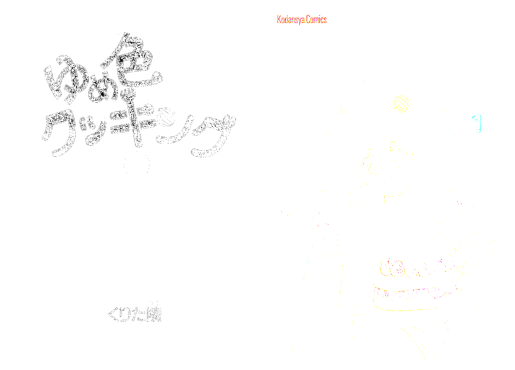

In [11]:
#!/usr/bin/env python
import manga109api
from PIL import Image, ImageDraw

def draw_rectangle(img, x0, y0, x1, y1, annotation_type):
    assert annotation_type in ["body", "face", "frame", "text"]
    color = {"body": "#258039", "face": "#f5be41",
             "frame": "#31a9b8", "text": "#cf3721"}[annotation_type]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1, y1], outline=color, width=10)

if __name__ == "__main__":
    book = "ARMS"
    page_index = 6

    p = manga109api.Parser(root_dir=manga109_dir)
    annotation = p.get_annotation(book=book)
    img = Image.open(p.img_path(book=book, index=page_index))

    for annotation_type in ["body", "face", "frame", "text"]:
        rois = annotation["page"][page_index][annotation_type]
        for roi in rois:
            draw_rectangle(img, roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"], annotation_type)

    # Display preprocessed image
    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Load and Preprocess Images with TensorFlow:


If you did see an image load up with rectangles around texts, you are now ready to integrate it with TF-Vision...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


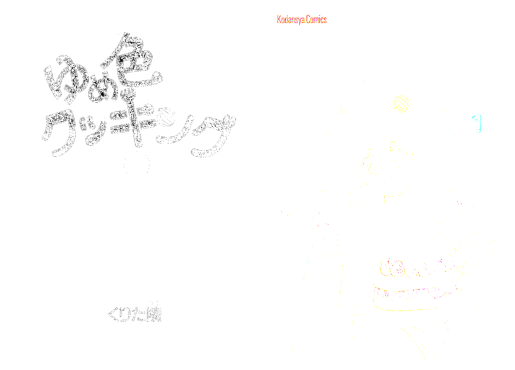

In [10]:
#!/usr/bin/env python

import tensorflow as tf
import manga109api
from PIL import Image, ImageDraw

# Initialize Manga109 API
manga109 = manga109api.Parser(root_dir=manga109_dir)

# Choose a manga volume and page index
volume = 'YumeiroCooking'
page_index = 0

# Load image using Manga109 API
image = Image.open(manga109.img_path(book=volume, index=page_index))

# Preprocess image using TensorFlow Keras
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.efficientnet.preprocess_input(image)

# Display preprocessed image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()


If the above worked for single book/volume, we can now iterate the ENTIRE books it knows about:

In [12]:
#!/usr/bin/env python

import tensorflow as tf
import manga109api

# Initialize Manga109 API
manga109 = manga109api.Parser(root_dir=manga109_dir)

# Iterate through all books
for book in manga109.books:
    print(f"Processing book: {book}")
    pages = manga109.get_pages(book)
    
    # Iterate through all pages in the book
    for page_index, page in enumerate(pages):
        # Load image using Manga109 API
        image1 = manga109.get_image(book, page_index)
        image = Image.open(manga109.img_path(book=volume, index=page_index))

        # Preprocess image using TensorFlow Keras
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.efficientnet.preprocess_input(image)

        # Display preprocessed image (optional)
        # import matplotlib.pyplot as plt
        # plt.imshow(image)
        # plt.axis('off')
        # plt.show()


Processing book: ARMS


AttributeError: 'Parser' object has no attribute 'get_pages'